### Loading Required Libraries

In [2]:
# import the necessary libraries

import pickle5 as pickle
from sklearn import svm
from modules import PreProcessing, functions
from sqlite3 import connect 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from itertools import chain
from collections import Counter
import nltk
import re
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings("ignore")

# to ensure all changes are reflected 
# in-case jupyter notebook was already oppened

from importlib import reload
reload(PreProcessing)
reload(functions)

project_dir = '/Users/nima/repository/Project_509'

ModuleNotFoundError: No module named 'pickle5'

### Section 1 - Create a Suport vector machine 

In [ ]:
databse_file = 'database.db'
main = connect(databse_file)

sql_statement_laod_data = '''
SELECT 
    reviews.course_name, 
    reviews.star,
    reviews.text,
    review_tokens.tokens

FROM review_tokens

JOIN reviews ON review_tokens.id = reviews.id

WHERE review_tokens.tokens IS NOT NULL
'''

df = pd.read_sql_query(sql_statement_laod_data, main)

# create a new column that holds tokens of clean_sentence
df['tokens'] = df['tokens'].apply(lambda x: x.split(' '))
df.sample(5)

,course_name,star,text,tokens
35516,python-network-data,5.0,Missed some of my assignments .faced some what...,"[miss, assign, face, difficulti]"
32482,introduction-cybersecurity-cyber-attacks,2.0,"That was just talking! Video, more Images, Gif...","[wa, talk, video, imag, etc, increas, insight,..."
54718,learning-how-to-learn,5.0,This is a fantastic course. The visuals are pe...,"[thi, fantast, cours, visual, perhap, particul..."
57162,learning-how-to-learn,5.0,"Excellent content, pace and professors. This s...","[excel, content, pace, professor, thi, mandato..."
25040,foundations-data,5.0,Easy to understand and presented in small bite...,"[easi, understand, present, small, bite, love]"


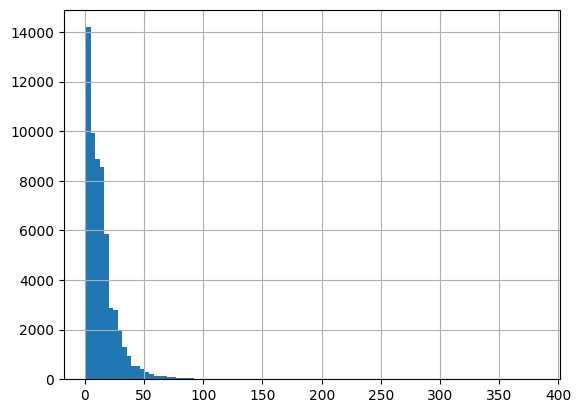

In [ ]:
# get number of tokens in each review
df['num_tokens'] = df['tokens'].apply(lambda x: len(x))

# show the distribution of number of tokens in each review
df['num_tokens'].hist(bins=100)
plt.show()

In [ ]:
# set seed for reproducibility
np.random.seed(12)

# get index of 20% of random data in the datafram for testing
test_index = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)

# set up the train and test
train = df[~df.index.isin(test_index)]
test = df[df.index.isin(test_index)]

In [ ]:
# get count of rows for each course_name in train set
train_count_org = \
    train.groupby('course_name').count()['tokens'].reset_index()

train_count_org.rename(columns={'tokens': 'train_count'}, inplace=True)
train_count_org

,course_name,train_count
0,ai-for-everyone,7753
1,excel-essentials,7914
2,foundations-data,7940
3,introduction-cybersecurity-cyber-attacks,2479
4,learning-how-to-learn,7992
5,python,7934
6,python-network-data,6137


In [ ]:
# drop rows in train set that have less than 5 tokens count
train_org = train.copy()

train = train[train['num_tokens'] >= 5]

# get count of rows after dropping rows with less than 5 tokens count
train_count_sub = \
    train.groupby('course_name').count()['tokens'].reset_index()

train_count_sub.rename(columns={'tokens': 'train_count_sub'}, inplace=True)

# join the two dataframes to compare the counts before and after dropping
train_count = train_count_org.merge(train_count_sub, on='course_name')

# make a column to show percentage of rows dropped
train_count['percent_dropped'] = \
    (train_count['train_count'] - train_count['train_count_sub']) / \
    train_count['train_count']

# reformat percent_dropped column to show percentage
train_count['percent_dropped'] = \
    train_count['percent_dropped'].apply(lambda x: '{:.1%}'.format(x))
    
train_count

,course_name,train_count,train_count_sub,percent_dropped
0,ai-for-everyone,7753,4890,36.9%
1,excel-essentials,7914,5702,28.0%
2,foundations-data,7940,5233,34.1%
3,introduction-cybersecurity-cyber-attacks,2479,1511,39.0%
4,learning-how-to-learn,7992,7881,1.4%
5,python,7934,7899,0.4%
6,python-network-data,6137,3700,39.7%


In [ ]:
# Since there are not a lot of rows with
# introduction-cybersecurity-cyber-attacks
# to train the data with, some random records
# will be added to over potential bias toward 
# the courses with higher records

# subtract train_count from largest train_count
train_count['diff'] = \
    train_count['train_count_sub'].max() - train_count['train_count_sub']

# sort train_count based on diff
train_count = train_count.sort_values('diff', ascending=False)
train_count

,course_name,train_count,train_count_sub,percent_dropped,diff
3,introduction-cybersecurity-cyber-attacks,2479,1511,39.0%,6388
6,python-network-data,6137,3700,39.7%,4199
0,ai-for-everyone,7753,4890,36.9%,3009
2,foundations-data,7940,5233,34.1%,2666
1,excel-essentials,7914,5702,28.0%,2197
4,learning-how-to-learn,7992,7881,1.4%,18
5,python,7934,7899,0.4%,0


In [ ]:
# resample records based on diff and create df_balanced
df_resample = pd.DataFrame()
for course_name in train_count['course_name']:
    resample_count = train_count[train_count['course_name'] == course_name]['diff'].values[0]
    course_resample = \
        train[train['course_name'] == course_name].sample(resample_count, replace=True)
    
    df_resample = pd.concat([df_resample, course_resample])

train_balanced = pd.concat([train, df_resample], ignore_index = True)

train_balanced_count = \
    train_balanced.groupby('course_name').count()['tokens']\
        .reset_index().rename(columns={'tokens': 'train_count_sub'})

train_balanced_count

,course_name,train_count_sub
0,ai-for-everyone,7899
1,excel-essentials,7899
2,foundations-data,7899
3,introduction-cybersecurity-cyber-attacks,7899
4,learning-how-to-learn,7899
5,python,7899
6,python-network-data,7899


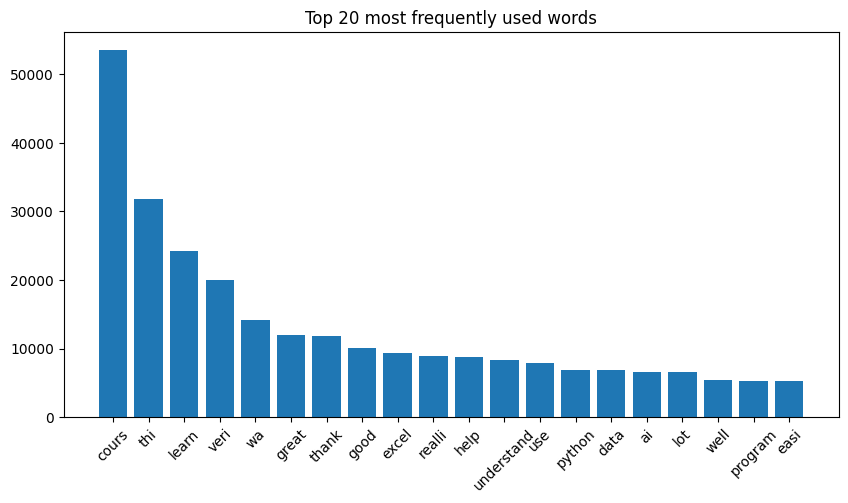

In [ ]:
words_to_train_with = Counter(chain.from_iterable(train_balanced['tokens']))

# plot the top 20 most frequently used in words_to_train_with
plt.figure(figsize=(10,5))
plt.title('Top 20 most frequently used words')
plt.bar(*zip(*words_to_train_with.most_common(20)))
plt.xticks(rotation=45)
plt.show()

In [ ]:
# make a tuple of tokens_keep and classification

def prepare_train_data(row, y_column):
    x = {token:True for token in row['tokens']}
    y = row[y_column]
    return (x, y)

train_data_course = \
    train_balanced.apply(prepare_train_data, y_column = 'course_name', axis=1)
train_data_course[0]

({'highli': True,
  'recommend': True,
  'anyon': True,
  'want': True,
  'start': True,
  'learn': True,
  'ai': True,
  'explain': True,
  'coher': True,
  'intuit': True,
  'way': True,
  'help': True,
  'lay': True,
  'foundat': True,
  'lifelong': True,
  'experi': True,
  'new': True,
  'career': True},
 'ai-for-everyone')

In [ ]:
model_nb = nltk.NaiveBayesClassifier.train(train_data_course)

In [ ]:
model_nb.show_most_informative_features(25)

Most Informative Features
                      ai = True           ai-for : founda =   3057.0 : 1.0
                  python = True           python : excel- =   2421.0 : 1.0
                      dr = True           python : founda =   1001.0 : 1.0
              cybersecur = True           introd : learni =    953.0 : 1.0
                   cyber = True           introd : python =    841.7 : 1.0
                 analyst = True           founda : python =    608.3 : 1.0
                   chuck = True           python : learni =    575.0 : 1.0
                 barbara = True           learni : ai-for =    552.3 : 1.0
                  analyt = True           founda : learni =    543.8 : 1.0
                   audio = True           introd : python =    422.4 : 1.0
                  andrew = True           ai-for : learni =    388.3 : 1.0
                     ibm = True           introd : python =    339.0 : 1.0
                     web = True           python : founda =    335.4 : 1.0

In [ ]:
words_to_train_with

In [ ]:
# make prediction of course name using the model_nb
def make_prediction_nb(tokens, model, use_words):
        X = {token:True for token in tokens if token in use_words}
        return model.classify(X)

test['predicted_course_name'] = \
    test['tokens'].apply(make_prediction_nb, 
                         model=model_nb, 
                         use_words=words_to_train_with)

test[['course_name', 'predicted_course_name']].sample(10)

,course_name,predicted_course_name
865,ai-for-everyone,ai-for-everyone
39851,python-network-data,python
22305,foundations-data,learning-how-to-learn
20628,foundations-data,learning-how-to-learn
46584,python,python
53854,learning-how-to-learn,learning-how-to-learn
19903,foundations-data,python
12716,excel-essentials,excel-essentials
9862,excel-essentials,learning-how-to-learn
24570,foundations-data,foundations-data


In [ ]:
# calculate the accuracy of the model
accuracy = nltk.classify.accuracy(model_nb, train_data_course)
print('Accuracy of the model: %s' % f'{accuracy:.2%}')

Accuracy of the model: 65.24%


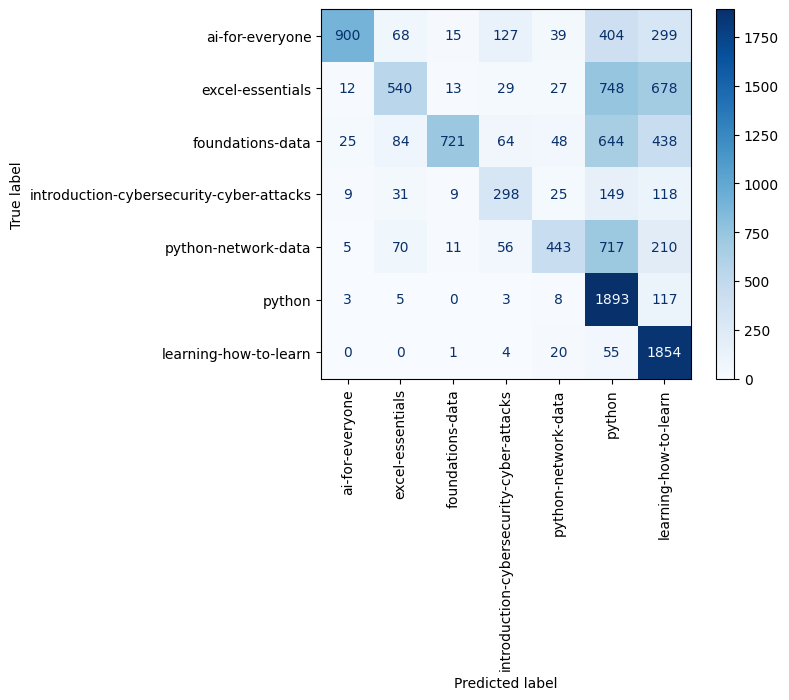

In [ ]:
# calculate the confusion matrix of the model using sklearn
classification_labels = test['course_name'].unique()
cmx = confusion_matrix(
    test['course_name'], 
    test['predicted_course_name'], 
    labels=classification_labels)

ConfusionMatrixDisplay(confusion_matrix=cmx, 
                       display_labels=list(classification_labels)).plot(cmap='Blues',xticks_rotation='vertical')
plt.show()

In [ ]:
# Make a dataframe that holds the confusion matrix
cmx_df = pd.DataFrame(cmx, index=classification_labels, columns=classification_labels)
cmx_df

,ai-for-everyone,excel-essentials,foundations-data,introduction-cybersecurity-cyber-attacks,python-network-data,python,learning-how-to-learn
ai-for-everyone,900,68,15,127,39,404,299
excel-essentials,12,540,13,29,27,748,678
foundations-data,25,84,721,64,48,644,438
introduction-cybersecurity-cyber-attacks,9,31,9,298,25,149,118
python-network-data,5,70,11,56,443,717,210
python,3,5,0,3,8,1893,117
learning-how-to-learn,0,0,1,4,20,55,1854


In [ ]:
# calculate the precision, recall, f1-measure of the model using sklearn
precision, recall, f1, _ = precision_recall_fscore_support(test['course_name'], test['predicted_course_name'], labels=classification_labels)

# average the precision, recall, f1-measure
precision_avg = np.average(precision)
recall_avg = np.average(recall)
f1_avg = np.average(f1)

# show the results
print('precision: %s \nrecall: %s \nf1-measure: %s' % 
      (f'{precision_avg:.2%}', f'{recall_avg:.2%}', f'{f1_avg:.2%}'))

precision: 67.22% 
recall: 53.67% 
f1-measure: 52.43%


In [ ]:
train_data_star = \
    train_balanced.apply(prepare_train_data, y_column = 'star', axis=1)

train_data_star[0]

({'highli': True,
  'recommend': True,
  'anyon': True,
  'want': True,
  'start': True,
  'learn': True,
  'ai': True,
  'explain': True,
  'coher': True,
  'intuit': True,
  'way': True,
  'help': True,
  'lay': True,
  'foundat': True,
  'lifelong': True,
  'experi': True,
  'new': True,
  'career': True},
 5.0)

In [ ]:
# make a dataframe of the train_data_star
train_data_star_df = \
    pd.DataFrame(train_data_star.tolist(), columns=['all_tokens', 'actual_value_star'])

# convert train_data_star_df['actual_value_star'] to int
train_data_star_df['actual_value_star'] = \
    train_data_star_df['actual_value_star'].astype(int)

# create a column for each word in tokens
for word in words_to_train_with:
    train_data_star_df[word] = \
        train_data_star_df['all_tokens'].apply(lambda x: x.get(word, False))

# drop the all_tokens column since it is no longer needed
train_data_star_df.drop('all_tokens', axis=1, inplace=True)

train_data_star_df.sample(5)

,actual_value_star,highli,recommend,anyon,want,start,learn,ai,explain,coher,...,agradecida,cerebro,cotidiana,humano,profesora,metalearn,studylearn,dra,optimis,podemo
41945,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12286,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30462,5,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28995,5,True,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5844,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# X is all columns except actual_value_star and y is actual_value_star
X_star = train_data_star_df.drop('actual_value_star', axis=1)
y_star = train_data_star_df['actual_value_star'].values

model_svm = svm.LinearSVC(random_state=110, class_weight='balanced')
model_svm.fit(X_star, y_star)

LinearSVC(class_weight='balanced', random_state=110)

In [ ]:
# make prediction of stars using the svm model
def make_prediction_svm(tokens, model, use_words):
        # if tokens exist in use_words, set the value to True, otherwise set the value to False
        tokens = {word: (word in tokens) for word in use_words}
        # make a dataframe of tokens
        tokens_df = pd.DataFrame([tokens])
        # make prediction
        prediction = model.predict(tokens_df)[0].round()
        return prediction

use_words = X_star.columns.to_list()

test['predicted_star'] = \
    test['tokens'].apply(make_prediction_svm, 
                         model=model_svm, 
                         use_words=use_words)

# convert the star and predicted_star to int
for col in ['star', 'predicted_star']:
        test[col] = test[col].astype(int)

test[['star', 'predicted_star']].sample(10)

SyntaxError: 'break' outside loop (3568140346.py, line 13)

In [ ]:
# calculate the accuracy of the model
accuracy = accuracy_score(test['star'], test['predicted_star'])
print('Accuracy of the model: %s' % f'{accuracy:.2%}')

In [ ]:
# calculate the confusion matrix of the model using sklearn
classification_labels = test['star'].unique()
cmx = confusion_matrix(
    test['star'], 
    test['predicted_star'], 
    labels=classification_labels)

ConfusionMatrixDisplay(confusion_matrix=cmx, 
                       display_labels=list(classification_labels)).plot(cmap='Blues')
plt.show()

In [ ]:
# export the model_nb and model_svm to pickle files
pickle.dump(model_nb, open('model_nb.pkl', 'wb'))
pickle.dump(model_svm, open('model_svm.pkl', 'wb'))

predict_star_words = X_star.columns.to_list()
with open('words_star.txt', 'w') as f:
    f.write('\n'.join(predict_star_words))
   
predict_course_words = [token for token in words_to_train_with] 
with open('words_course.txt', 'w') as f:
    f.write('\n'.join(predict_course_words))